# Learning XOR

#### with pytorch

In [1]:
import numpy as np
from tqdm.notebook import tqdm
import torch

In [2]:
one_d_data = np.array([0, 1])

INPUT_DATA = np.array(np.meshgrid(one_d_data, one_d_data)).T.reshape(-1, 2)
INPUT_DATA


array([[0, 0],
       [0, 1],
       [1, 0],
       [1, 1]])

In [3]:
INPUT_LABEL = INPUT_DATA[:, 0] ^ INPUT_DATA[:, 1]
INPUT_LABEL

array([0, 1, 1, 0])

## Wrap around pytorch Dataset

In [4]:
from torch.utils.data import Dataset


class XORDataset(Dataset):
    def __init__(self, dimensions=2, input_range=[0, 1], output_dtype=np.float32):
        self.xx = np.array(np.meshgrid(*[input_range for _ in range(dimensions)])).T.reshape(-1, dimensions)
        self.y = np.copy(self.xx[:, 0])  # Make sure to copy data
        for i in range(1, dimensions):
            self.y ^= self.xx[:, i]
        self.output_dtype = output_dtype

    def __len__(self):
        return len(self.xx)

    def __getitem__(self, indx):
        return self.xx[indx, :].astype(self.output_dtype), self.y[indx].astype(self.output_dtype)

xor_2d_dataset = XORDataset()

In [5]:
from torch.utils.data import DataLoader

def transform(x):
    return x.float()

data_loader = DataLoader(xor_2d_dataset, batch_size=2)

batch_x, batch_y = list(data_loader)[0]
print(batch_x, batch_y)

print(batch_x.dtype)

tensor([[0., 0.],
        [0., 1.]]) tensor([0., 1.])
torch.float32


In [6]:
from collections import defaultdict
import matplotlib.pyplot as plt

class Logger:
    def __init__(self, visual_period=100):
        self.metrics = defaultdict(list)
        self.visual_period = visual_period

    def log_metric(self, metric, label, ts):
        self.metrics[label].append((ts, metric))
        if ts % self.visual_period == self.visual_period - 1:
            plt.plot(*zip(*self.metrics[label]))
            plt.show()

    def log_image(self, *args):
        print(*args)

    def save_model(self):
        pass

In [7]:
from tqdm.notebook import tqdm
import torch


def train_loop(model, epochs, optimizer_fn, loss_fn, training_loader, validation_loader, logger):
    optimizer = optimizer_fn(model.parameters())  # Instanciate here so to reduce bugs
    for epoche_i in epochs:
        model.train()
        train_epoche(epoche_i, model, optimizer, loss_fn, training_loader, logger=logger)


def train_epoche(epoch_index, model, optimizer, loss_fn, training_loader, logger):
    running_loss, running_count = 0., 0
    for i, (inputs, labels) in enumerate(training_loader):

        # Zero your gradients for every batch!
        optimizer.zero_grad()

        outputs = model(inputs)

        # Compute the loss and its gradients
        loss = loss_fn(outputs, labels)

        loss.backward()

        # Adjust learning weights
        optimizer.step()

        # Gather data and report
        batch_size = len(inputs)
        running_loss += loss.item() * batch_size
        running_count += batch_size

    total_train_loss = running_loss / running_count

    logger.log_metric(total_train_loss, 'Loss/train', epoch_index)

/Users/arsen/Workspace/python-nn-playground/.venv/3.11/lib/python3.11/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


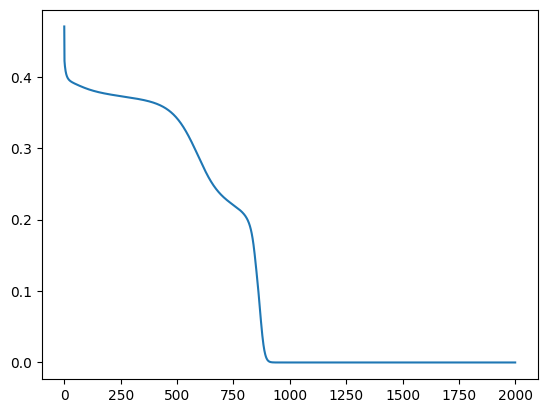

In [9]:

## TRAINING IN A SEPARATE CELL FOR PURPOSE (ideally should be a function)
torch.manual_seed(420)

from functools import partial
from torch import nn
import torch


class TwoLayerMLP(nn.Sequential):
    def __init__(self, input_dim, middle_dim=None, activation_layer=nn.Sigmoid):
        layers = [
            nn.Linear(input_dim, middle_dim or input_dim, bias=True),
            activation_layer(),
            nn.Linear(middle_dim or input_dim, 1, bias=True),
        ]
        super().__init__(*layers)

_EPOCHS = 2_000
_DIMENSION = 2

model = TwoLayerMLP(input_dim=_DIMENSION, middle_dim=2)   # Square 2 x 2 network

xor_2d_dataset = XORDataset(dimensions=2)

sgd_with_lr_02 = partial(torch.optim.SGD, lr=0.2)

mse_loss_fn = nn.MSELoss()

torch.manual_seed(21)
train_loop(model,
           list(range(0, 1 + _EPOCHS)),
            sgd_with_lr_02,
            mse_loss_fn,
            DataLoader(xor_2d_dataset, batch_size=1, shuffle=False),
            None,
            Logger(visual_period=_EPOCHS))

In [10]:
def activation_experiment(activation_layer, optimizer_fn):
    torch.manual_seed(21)
    
    _model = TwoLayerMLP(input_dim=_DIMENSION, middle_dim=2, activation_layer=activation_layer)
    
    train_loop(_model,
               list(range(0, 1 + _EPOCHS)),
               optimizer_fn,
               mse_loss_fn,
                DataLoader(xor_2d_dataset, batch_size=1, shuffle=False),
               None,
               Logger(visual_period=_EPOCHS))
    
    return _model

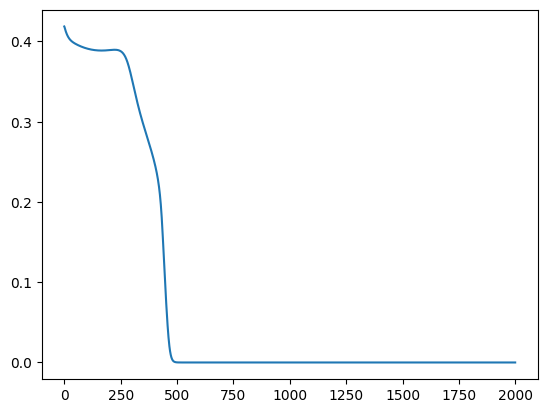

TwoLayerMLP(
  (0): Linear(in_features=2, out_features=2, bias=True)
  (1): Sigmoid()
  (2): Linear(in_features=2, out_features=1, bias=True)
)

In [12]:
activation_experiment(nn.Sigmoid, sgd_with_lr_02)

/Users/arsen/Workspace/python-nn-playground/.venv/3.11/lib/python3.11/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


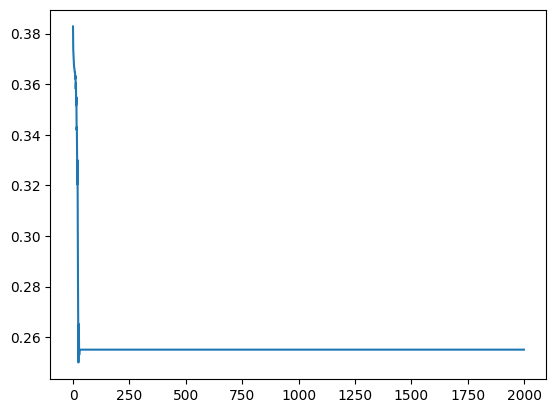

TwoLayerMLP(
  (0): Linear(in_features=2, out_features=2, bias=True)
  (1): ReLU()
  (2): Linear(in_features=2, out_features=1, bias=True)
)

In [13]:
activation_experiment(nn.ReLU, sgd_with_lr_02)

/Users/arsen/Workspace/python-nn-playground/.venv/3.11/lib/python3.11/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


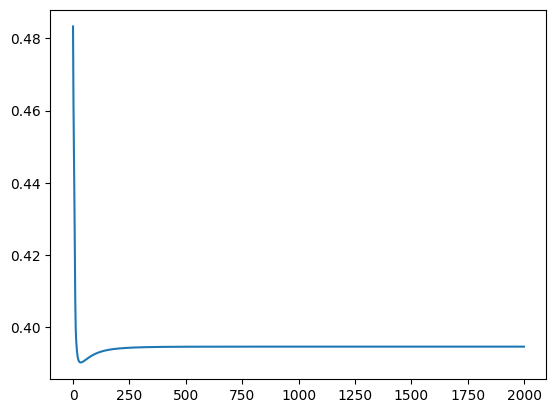

TwoLayerMLP(
  (0): Linear(in_features=2, out_features=2, bias=True)
  (1): Tanh()
  (2): Linear(in_features=2, out_features=1, bias=True)
)

In [14]:
activation_experiment(nn.Tanh, sgd_with_lr_02)

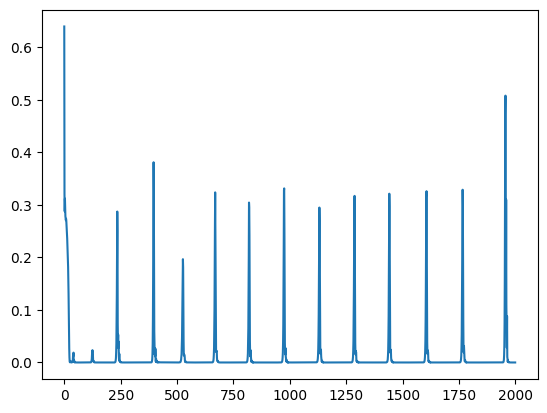

TwoLayerMLP(
  (0): Linear(in_features=2, out_features=2, bias=True)
  (1): Tanh()
  (2): Linear(in_features=2, out_features=1, bias=True)
)

In [18]:
adam_with_lr_02 = partial(torch.optim.Adam, lr=0.2)

activation_experiment(nn.Tanh, adam_with_lr_02)

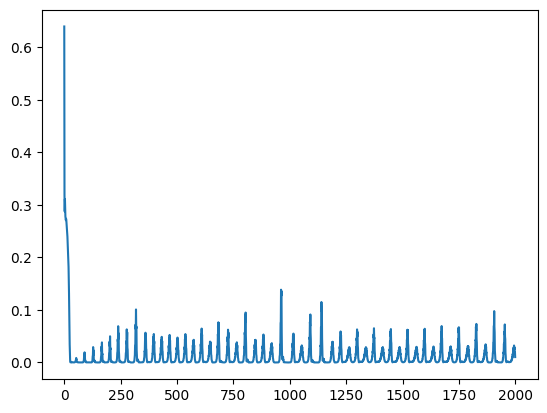

TwoLayerMLP(
  (0): Linear(in_features=2, out_features=2, bias=True)
  (1): Tanh()
  (2): Linear(in_features=2, out_features=1, bias=True)
)

In [24]:
activation_experiment(nn.Tanh, partial(torch.optim.AdamW, lr=0.2))

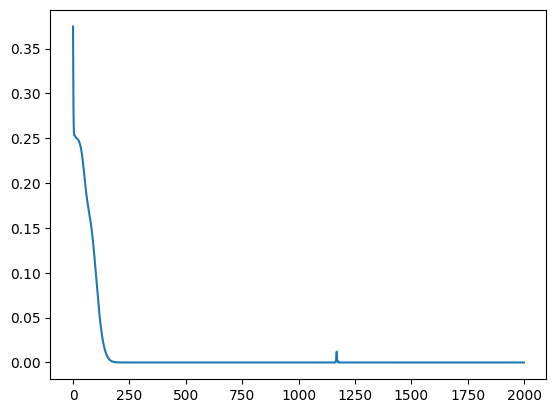

TwoLayerMLP(
  (0): Linear(in_features=2, out_features=2, bias=True)
  (1): Tanh()
  (2): Linear(in_features=2, out_features=1, bias=True)
)

In [28]:
activation_experiment(nn.Tanh, partial(torch.optim.Adam, lr=0.02))

/Users/arsen/Workspace/python-nn-playground/.venv/3.11/lib/python3.11/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


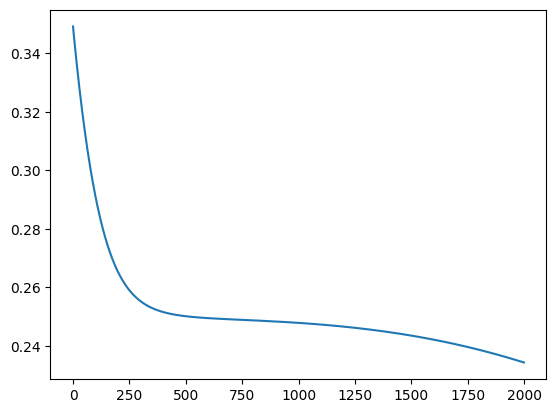

TwoLayerMLP(
  (0): Linear(in_features=2, out_features=2, bias=True)
  (1): Tanh()
  (2): Linear(in_features=2, out_features=1, bias=True)
)

In [22]:
activation_experiment(nn.Tanh, partial(torch.optim.Adam, lr=3e-4))  # Karpathy's Answer

/Users/arsen/Workspace/python-nn-playground/.venv/3.11/lib/python3.11/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


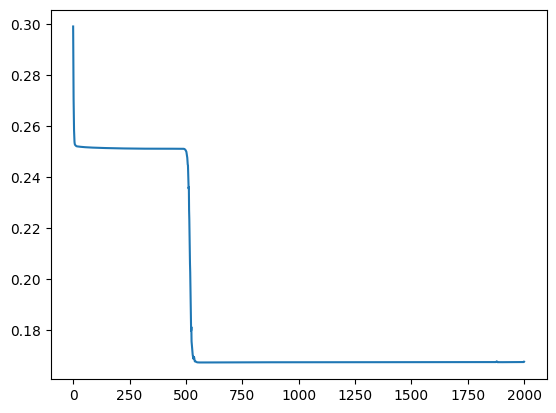

TwoLayerMLP(
  (0): Linear(in_features=2, out_features=2, bias=True)
  (1): ReLU()
  (2): Linear(in_features=2, out_features=1, bias=True)
)

In [37]:
trained_relu_network = activation_experiment(nn.ReLU, partial(torch.optim.Adam, lr=0.02))
trained_relu_network

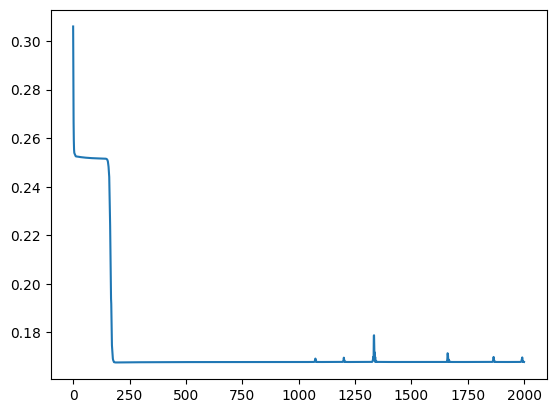

TwoLayerMLP(
  (0): Linear(in_features=2, out_features=2, bias=True)
  (1): ReLU()
  (2): Linear(in_features=2, out_features=1, bias=True)
)

In [34]:
activation_experiment(nn.ReLU, partial(torch.optim.Adam, lr=0.03))

/Users/arsen/Workspace/python-nn-playground/.venv/3.11/lib/python3.11/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


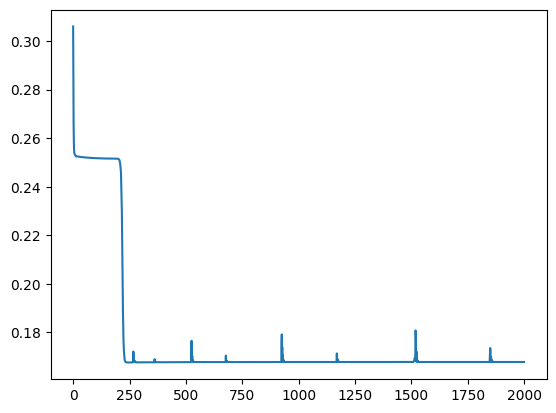

TwoLayerMLP(
  (0): Linear(in_features=2, out_features=2, bias=True)
  (1): ReLU()
  (2): Linear(in_features=2, out_features=1, bias=True)
)

In [35]:
activation_experiment(nn.ReLU, partial(torch.optim.AdamW, lr=0.03))

In [38]:
trained_relu_network

TwoLayerMLP(
  (0): Linear(in_features=2, out_features=2, bias=True)
  (1): ReLU()
  (2): Linear(in_features=2, out_features=1, bias=True)
)

In [39]:
optimizer = torch.optim.SGD(model.parameters(), lr=0.2)
loss_fn = nn.MSELoss()


def check_gradients(model, batch, optimizer, loss_fn):
    # Zero your gradients for every batch!
    optimizer.zero_grad()

    inputs, labels = batch
    outputs = model(inputs)
    # Compute the loss and its gradients
    loss = loss_fn(outputs, labels)
    loss.backward(retain_graph=True)

    return draw_gradient_and_annotate(model, batch)


In [40]:
single_point_dataloader = list(DataLoader(xor_2d_dataset, batch_size=1, shuffle=False))

In [42]:
from graphviz import Digraph
np.set_printoptions(precision=4)

def draw_gradient_and_annotate(sequencial_model, batch):
    dot = Digraph()
    dot.attr(compound='true')

    with dot.subgraph(name='cluster_inputs') as c:
        c.attr(label='Input data')
        input, label = batch
        c.node(name=str(id(input)), label=f'{input}')
        c.node(name=str(id(label)), label=f'{label}')
        
    prev_layer, prev_p = batch, input

    for layer in sequencial_model:
        if list(layer.parameters()):
            with dot.subgraph(name=f'cluster_{id(layer)}') as cluster:
                cluster.attr(label=str(layer), shape='')
                for p in layer.parameters():
                    cluster.node(name=str(id(p)), label=f'{p.data.numpy()} \n --------- \n {p.grad.numpy() if p.grad is not None else None}')
        else:
            p = layer
            dot.node(name=str(id(layer)), label=str(layer))
        # dot.node(name=str(id(layer)), label=f'{layer} \n grad: {[p.grad for p in layer.parameters()]}', shape='box')
        if prev_layer:
            dot.edge(str(id(prev_p)), str(id(p)), ltail=f'cluster_{id(prev_layer)}', lhead=f'cluster_{id(layer)}')
        prev_layer, prev_p = layer, p

    return dot


/Users/arsen/Workspace/python-nn-playground/.venv/3.11/lib/python3.11/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


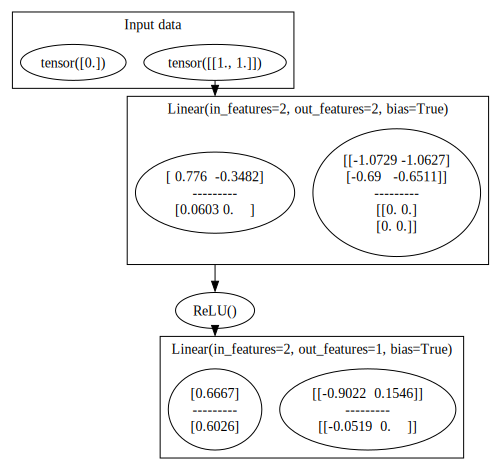

In [46]:
check_gradients(
    trained_relu_network,
    single_point_dataloader[3],
    torch.optim.SGD(model.parameters(), lr=0.2),
    nn.MSELoss(),
)

# The problem
with RELU is that the network get's stuck with negative weights and positive inputs.. And can't learn any longer :(


How do we get here??? Also is it? bias can change


In [50]:
def relu_experiment(optimizer_fn, epochs):
    torch.manual_seed(21)
    
    _model = TwoLayerMLP(input_dim=_DIMENSION, middle_dim=2, activation_layer=nn.ReLU)
    
    train_loop(_model,
               list(range(0, epochs)),
               optimizer_fn,
               mse_loss_fn,
                DataLoader(xor_2d_dataset, batch_size=1, shuffle=False),
               None,
               Logger(visual_period=epochs))
    
    return _model

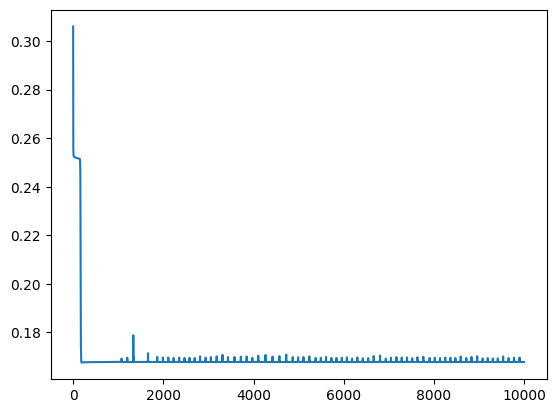

TwoLayerMLP(
  (0): Linear(in_features=2, out_features=2, bias=True)
  (1): ReLU()
  (2): Linear(in_features=2, out_features=1, bias=True)
)

In [53]:
relu_experiment(partial(torch.optim.Adam, lr=0.03), 10000)

/Users/arsen/Workspace/python-nn-playground/.venv/3.11/lib/python3.11/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


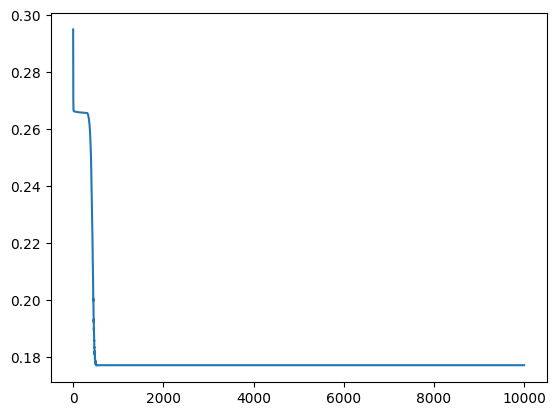

In [55]:
relu_sgd_trained = relu_experiment(partial(torch.optim.SGD, lr=0.03), 10000)

/Users/arsen/Workspace/python-nn-playground/.venv/3.11/lib/python3.11/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


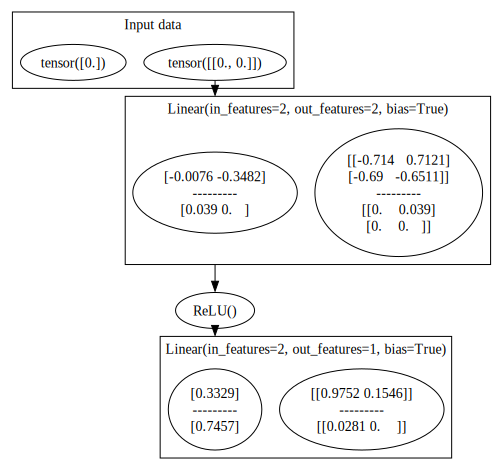

In [59]:
check_gradients(
    relu_sgd_trained,
    single_point_dataloader[0],
    torch.optim.SGD(model.parameters(), lr=0.2),
    nn.MSELoss(),
)

In [320]:

def draw_first_layer_neurons(model):
    l0_weights, l0_bias = list(list(model)[0].parameters())

    w, b = l0_weights.data.numpy(), l0_bias.data.numpy()

    plt.scatter(*INPUT_DATA[INPUT_LABEL == 0].T, s=50, color='blue')
    plt.scatter(*INPUT_DATA[INPUT_LABEL == 1].T, s=50, color='red')

    xxx = np.arange(-0.1, 1.1, 0.1)

    for i in range(len(w)):
        y = ((xxx * w[i, 0] + b[i]) / (-w[i, 1]))
        plt.plot(xxx, y, label=f'neuron_{i}')

    plt.legend()
    plt.show()



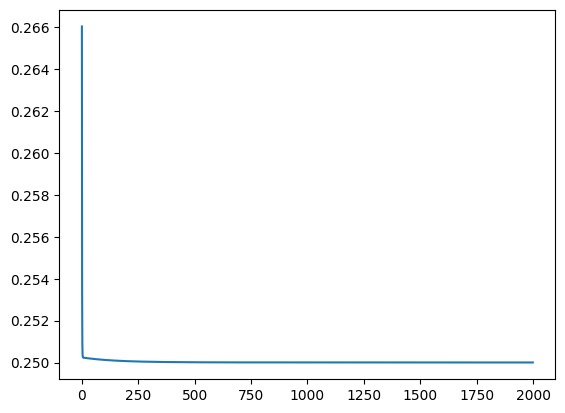

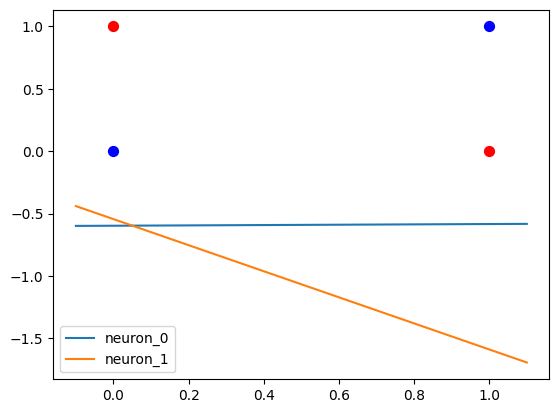

In [382]:
combined_trained_model = batching_experiment(valid_loader)

In [395]:
combined_trained_model._modules['0'].bias

Parameter containing:
tensor([ 0.0978, -0.3518], requires_grad=True)

In [80]:

def draw_loss_function(model, batch, layer_label='2', layer_shape=(1, 2)):
    plt.figure(figsize=(20, 6))
    with torch.no_grad():
        xxx = np.arange(-1, 1, 0.01)
        for i in range(layer_shape[0]):
            for j in range(layer_shape[1]):
                yyy = []
                old_weight = model._modules[layer_label].weight[i, j].data.numpy().copy()
                print('old', old_weight)
                for w in xxx:
                    model._modules[layer_label].weight[i, j] = torch.Tensor([w])
    
                    inputs, labels = batch
    
                    outputs = model(inputs)
                    # Compute the loss and its gradients
                    loss = loss_fn(outputs, labels)
    
                    yyy.append(loss.item())
    
                model._modules[layer_label].weight[i, j] = torch.Tensor(old_weight)
    
                plt.plot(xxx, yyy, label=f'layer {layer_label}, weight = {i, j}')
                plt.bar(old_weight, 1, 0.01, label=f'{i, j}', alpha=0.2)
    
            # bias
            yyy = []
            old_weight = model._modules[layer_label].bias[i].data.numpy().copy()
            for w in xxx:
                model._modules[layer_label].bias[i] = torch.Tensor([w])
    
                inputs, labels = batch
    
                outputs = model(inputs)
                # Compute the loss and its gradients
                loss = loss_fn(outputs, labels)
    
                yyy.append(loss.item())
    
            model._modules[layer_label].bias[i] = torch.Tensor(old_weight)
    
            plt.plot(xxx, yyy, label=f'layer {layer_label}, bias = {i}')
            plt.bar(old_weight, 1, 0.01, label=f'bias {i}', alpha=0.2)
        plt.legend()
        plt.show()
    

old -1.0
old 0.35983497


/Users/arsen/Workspace/python-nn-playground/.venv/3.11/lib/python3.11/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


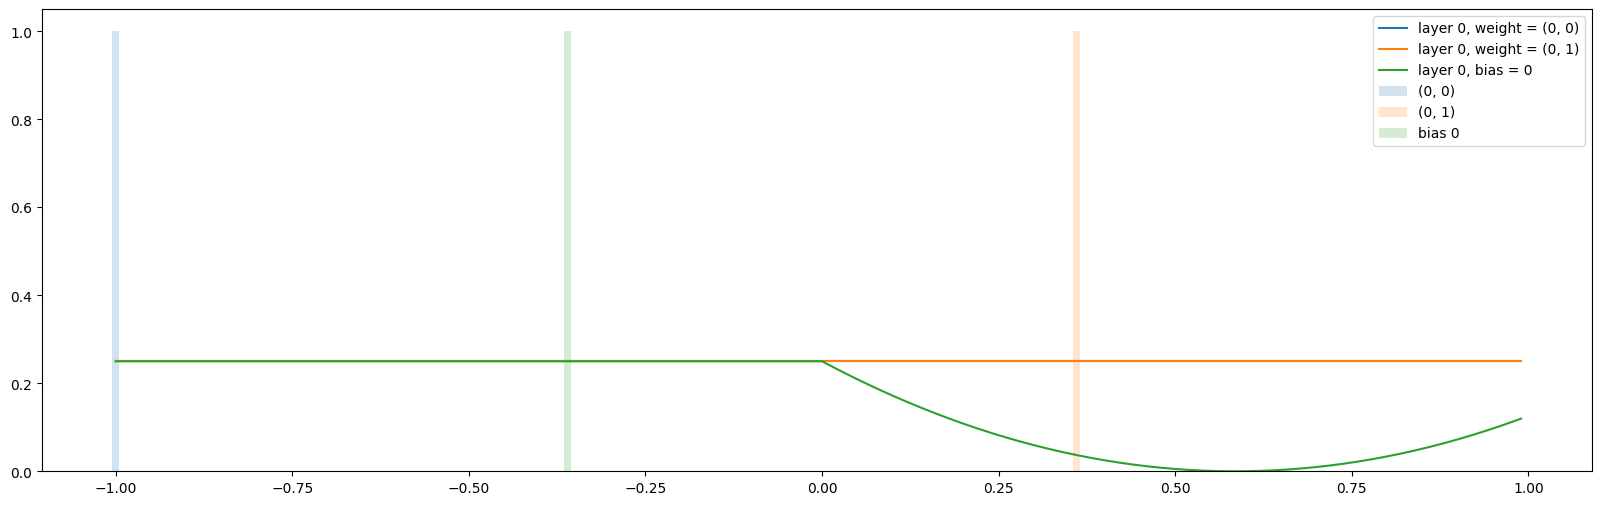

old -1.0
old 0.35983497


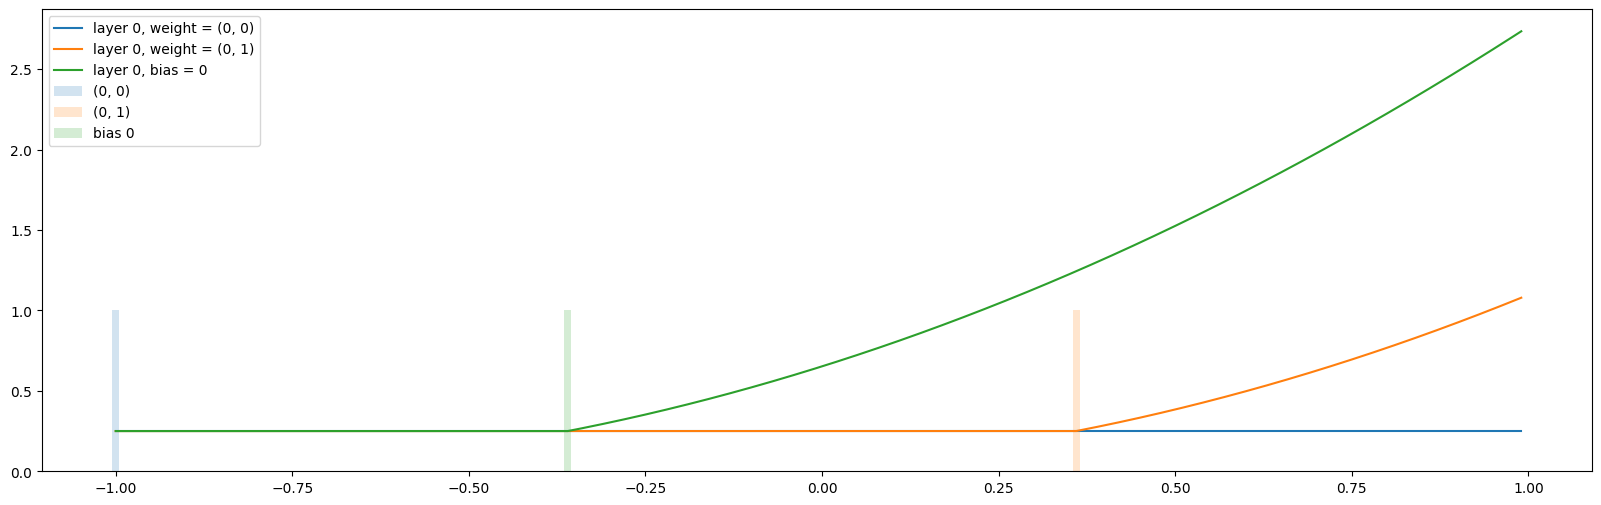

old -1.0
old 0.35983497


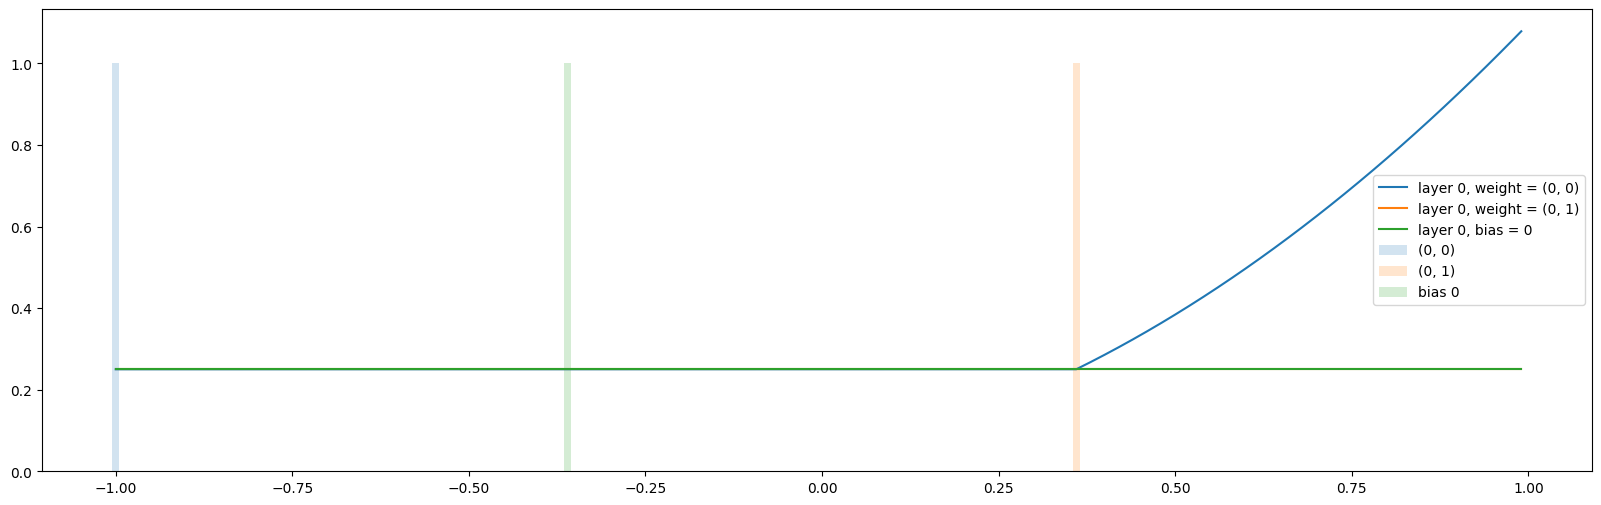

old -1.0
old 0.35983497


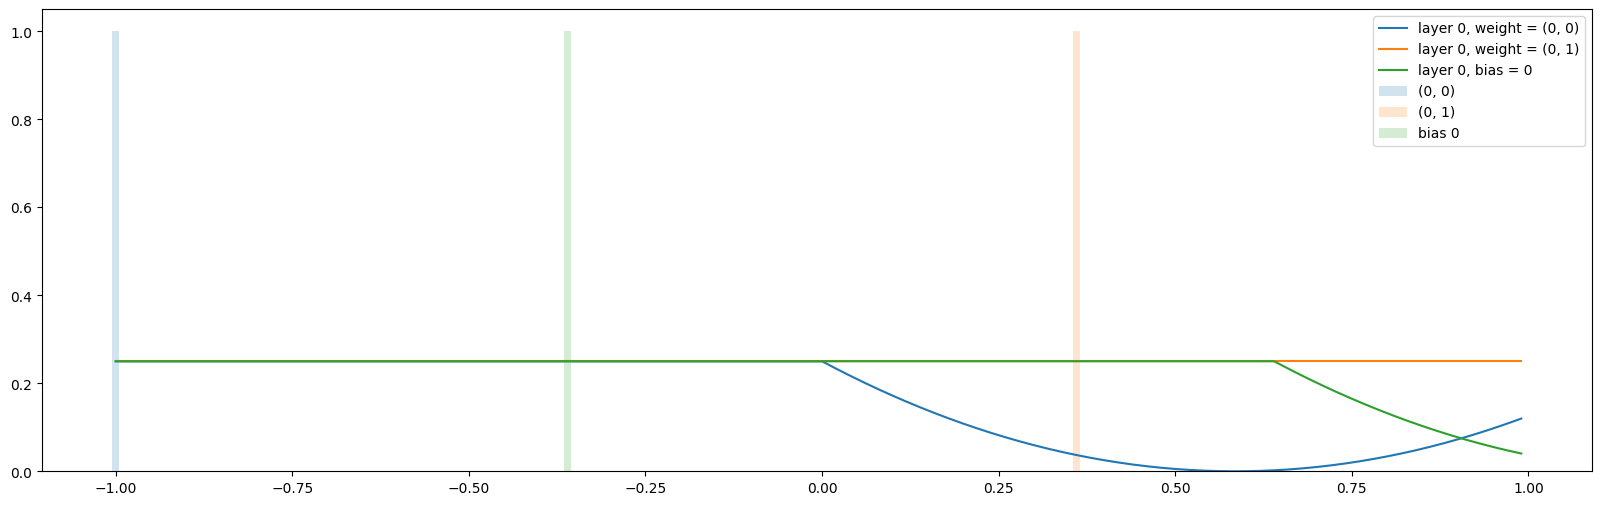

In [102]:
draw_loss_function(relu_sgd_trained, single_point_dataloader[0], layer_label='0')
draw_loss_function(relu_sgd_trained, single_point_dataloader[1], layer_label='0')
draw_loss_function(relu_sgd_trained, single_point_dataloader[2], layer_label='0')
draw_loss_function(relu_sgd_trained, single_point_dataloader[3], layer_label='0')

old -1.0
old 0.35983497
old -0.6900329
old -0.65110844


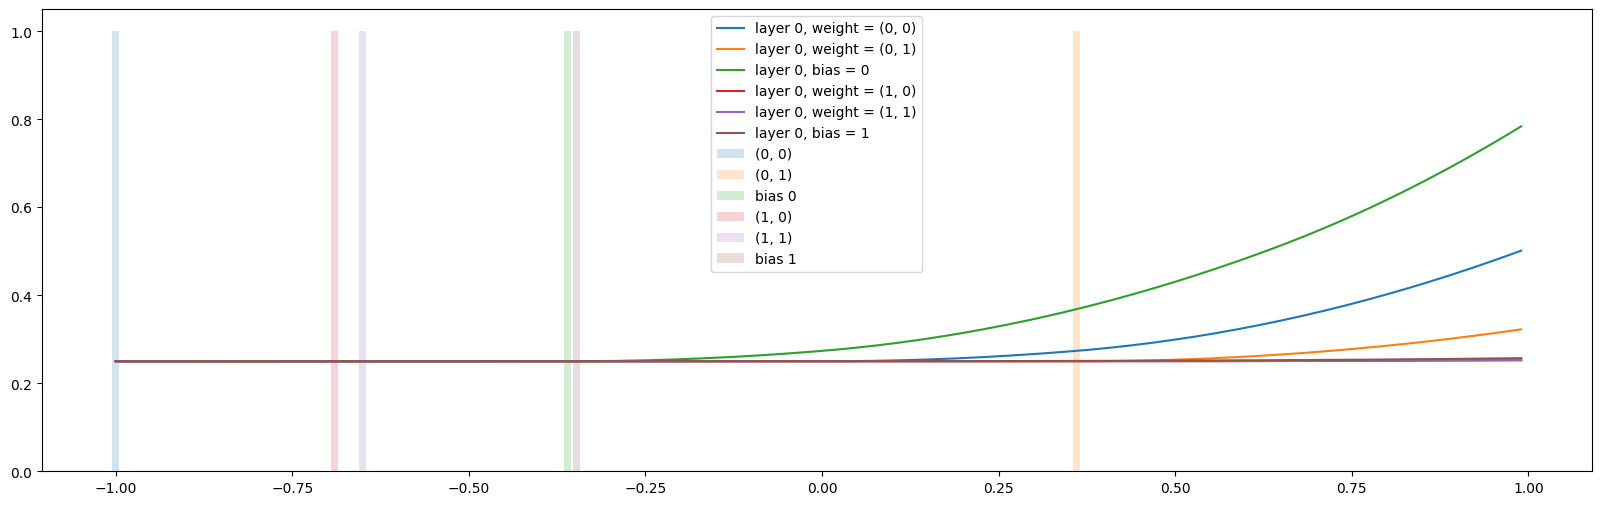

old -0.8547184
old 0.15462863


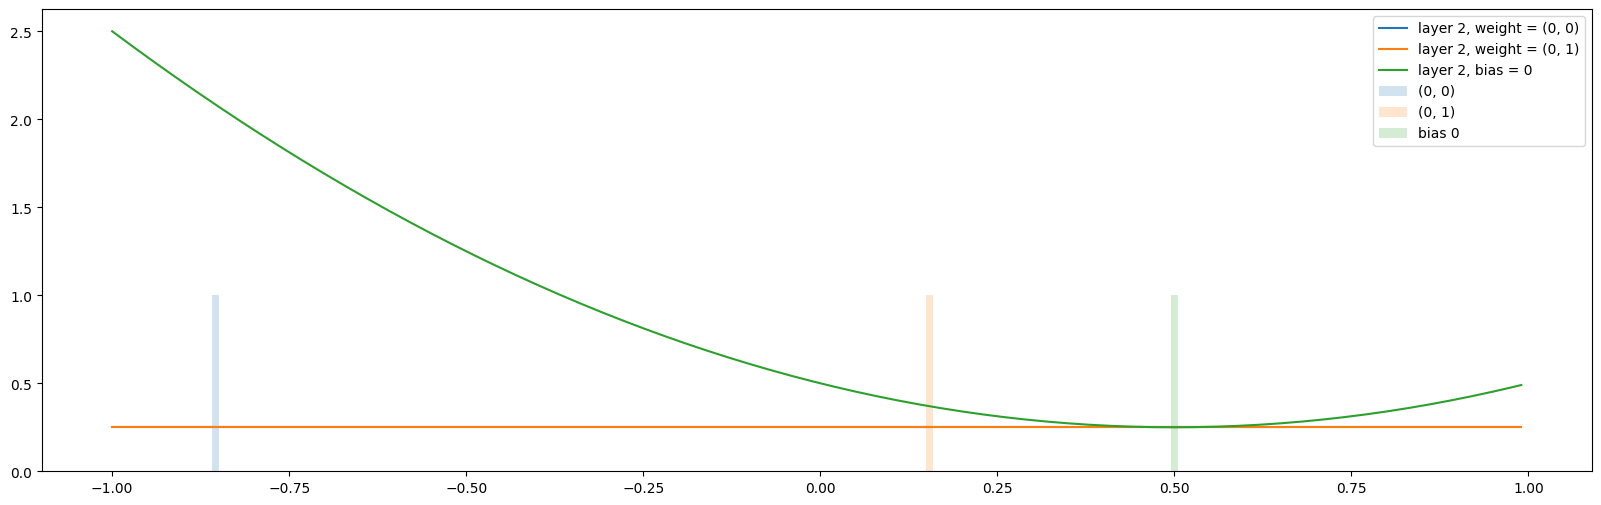

In [101]:
valid_loader = list(DataLoader(xor_2d_dataset, batch_size=4, shuffle=False))

draw_loss_function(relu_sgd_trained, valid_loader[0], layer_label='0', layer_shape=(2, 2))
draw_loss_function(relu_sgd_trained, valid_loader[0], layer_label='2')

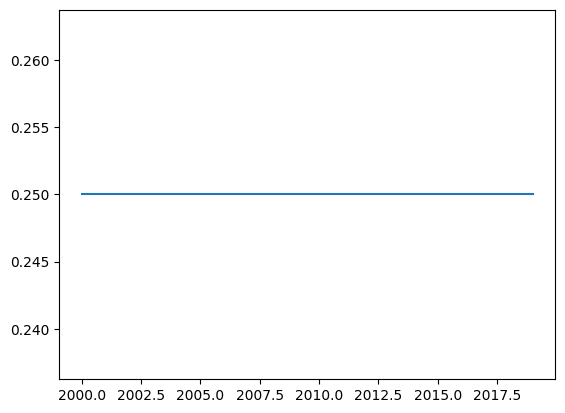

In [100]:
train_loop(relu_sgd_trained,
           list(range(_EPOCHS, 20 + _EPOCHS)),
            sgd_with_lr_02,
            mse_loss_fn,
            valid_loader,
            None,
            Logger(visual_period=20))

/Users/arsen/Workspace/python-nn-playground/.venv/3.11/lib/python3.11/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([4])) that is different to the input size (torch.Size([4, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


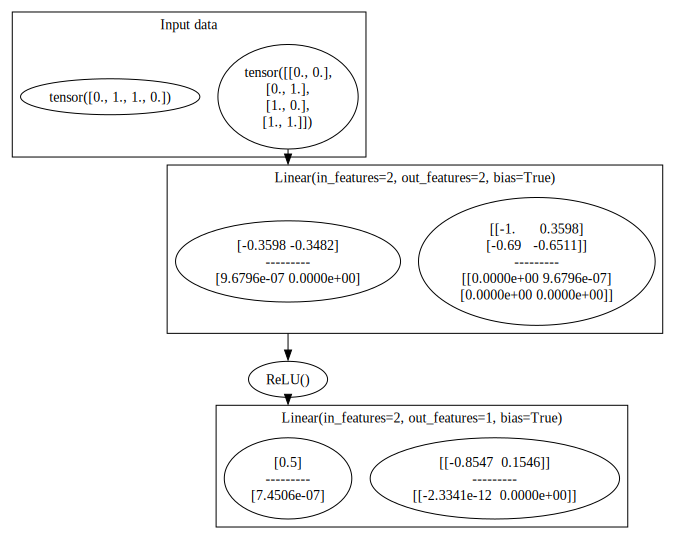

In [103]:
check_gradients(
    relu_sgd_trained,
    valid_loader[0],
    torch.optim.SGD(model.parameters(), lr=0.2),
    nn.MSELoss(),
)

# Shouldn't have trained with valid_loader, it got to an "average" solution... 

I should experiment with learning rate decay.. maybe I can teach RELU using that...

###

